__File: srg_observables_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     August 28, 2019__

This notebook creates a few figures showing phase shifts and momentum distributions from NN potentials for initial or SRG-evolved potentials. Each function creates and saves a figure to the __Figures/SRG_observables__ folder. Below is an outline of each function:
* phase_shifts - Plots NN phase shifts from EM N$^3$LO, RKE N$^3$LO, Gezerlis N$^2$LO potentials.
* deuteron_momentum_distribution - Plots a semi-log figure of deuteron momentum distributions comparing initial and SRG-evolved $\psi^2$. Note this depicts $\psi(s)^2$ not $|\psi(s)|^2 = \psi^{\dagger}(0) U^{\dagger}(s) U(s) \psi(0) = |\psi(0)|^2$.
* continuum_state_distribution - Analog of the deuteron_momentum_distribution function but for some state $\epsilon_k$ > 0 MeV.

__Revision history:<br/>__
* August 30, 2019 - Finalized phase_shifts, deuteron_momentum_distribution, and continuum_state_distribution functions.

In [1]:
from os import chdir, getcwd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
import observables as ob
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Plotting functions__

In [2]:
def phase_shifts(channel):
    """
    Plots NN phase shifts [deg] as a function of lab energy [MeV] for the default potentials: EM N3LO (500 MeV),
    RKE N3LO (450 MeV), and Gezerlis N2LO (1 fm). Must specify the partial wave channel.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    
    Saves
    -----
    file_name = phase_shifts_ with an extension based off the given argument.
    file_type = .pdf
    
    """
    
    # Current working directory
    cwd = getcwd()
    
    
    # Set-up #
    
    # Lab energy array in MeV
    e_max = 800.0 # Max value
    M = 400 # Number of points in array
    e_array = np.linspace(0, e_max, M)
    
    # Number of points in momentum-mesh
    ntot = 120
    
    # Specifications for EM N3LO (500 MeV), RKE N3LO (450 MeV), and Gez. N2LO (1.0 fm) in the format 
    # (kvnn, kmax, kmid)
    potential_specifications = [(10, 30.0, 4.0), (106, 8.0, 2.0), (222, 10.0, 2.0)]
    
    # Store different phase shifts and momentum arrays in dictionary with kvnn keys
    d = {}
    
    # Loop over specifications and add to dictionary
    for spec in potential_specifications:
        
        # Set kvnn, kmax, and kmid
        kvnn = spec[0]
        kmax = spec[1]
        kmid = spec[2]
        
        # Load momentum, weights, and potential
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
    
        # Calculate phase shifts in the Stapp convention
        phase_shifts_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights, convention='Stapp')
        # Add only delta_a_array to dictionary which is the first column vector of phases
        delta_a_array = phase_shifts_array[:, 0]
        d[kvnn] = delta_a_array
        
        
    # Plot specifications #
    
    # Limits of x and y axes
    xlim = [0.0, e_array.max()]
    ylim = [-40.0, 180.0]
    
    # Labels
    x_label = r'$E_{lab}$' + ' [MeV]'
    y_label = r'$\delta$' + ' [deg]'
    EM_label = 'EM N' + r'$^3$' + 'LO' # EM N3LO
    RKE_label = 'RKE N' + r'$^3$' + 'LO' # RKE N3LO
    Gez_label = 'Gez. N' + r'$^2$' + 'LO' # Gez. N2LO
    
    # Fontsize for labels
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 16
    
    # Location of labels
    legend_label_location = 'upper right'
    
    
    # Plot line plot #
    
    plt.close('all')
    
    f, ax = plt.subplots()
    
    # Add lines to plot
    ax.plot(e_array, d[10], color='xkcd:black', label=EM_label)
    ax.plot(e_array, d[106], color='xkcd:red', linestyle='dashdot', label=RKE_label)
    ax.plot(e_array, d[222], color='xkcd:blue', linestyle='dashed', label=Gez_label)
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    
    
    # Save figure #
    
    # Name of the file
    file_name = 'phase_shifts_' + channel
    
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [3]:
def deuteron_momentum_distribution(kvnn, kmax, kmid, ntot, generator, lamb, lambda_bd=0.00):
    """
    Plots a semi-log figure of the deuteron momentum distribution |psi_d(k)|^2 [fm^3] as a function of momentum k 
    [fm^-1] with psi_d(0) from the bare Hamiltonian and psi_d(lambda) from an evolved Hamiltonian at a given 
    value of lambda. Must specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda in units fm^-1.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = deuteron_momentum_distribution_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    
    # Current working directory
    cwd = getcwd()
    
    
    # Set-up #
    
    # Load momentum distributions
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Load unitary transformation
    # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
    # Compute initial and evolved wave functions
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
    u_evolved = psi_evolved[:ntot] # 3S1 component
    w_evolved = psi_evolved[ntot:] # 3D1 component
    
    # Initial and evolved momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
    

    # Plot specifications #
    
    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
    
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_label = r'$\phi_d^2$' + ' [fm' + r'$^3$' + ']'
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%d$' % lambda_bd + ' fm' + r'$^{-1}$'
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    
    # Fontsize for labels
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 16
    generator_label_size = 20
    
    # Location of labels
    legend_label_location = 'upper right'
    generator_label_location = 'lower left'
    
    
    # Plot semi-log line plot #
    
    plt.close('all')
    
    f, ax = plt.subplots()
    
    # Add lines to plot
    ax.semilogy(k_array, phi_squared_evolved, color='xkcd:red', label=lambda_label%lamb)
    ax.semilogy(k_array, phi_squared_initial, color='xkcd:black', linestyle='dotted', label=lambda_inf_label)
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add generator label as anchored text
    anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                 loc=generator_label_location, frameon=False)
    ax.add_artist(anchored_text)
    
    
    # Save figure #
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'deuteron_momentum_distribution_kvnn%d_%s%.2f_lamb%.1f'%(kvnn, generator, lambda_bd, lamb)
    else:
        name = 'deuteron_momentum_distribution_kvnn%d_%s_lamb%.1f'%(kvnn, generator, lamb)
        
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(name)
    
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
def continuum_state_momentum_distribution(eps, kvnn, kmax, kmid, ntot, generator, lamb, lambda_bd=0.00):
    """
    Plots a semi-log figure of the momentum distribution |psi_eps(k)|^2 [fm^3] as a function of momentum k 
    [fm^-1] with psi_eps(0) from the bare Hamiltonian and psi_eps(lambda) from an evolved Hamiltonian at a given 
    value of lambda. Epsilon specifies the energy of the state (i.e. epsilon = -2.22 MeV would corrspond to 
    deuteron). Must specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc.
    
    Parameters
    ----------
    eps : float
        Energy value in units MeV.
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda in units fm^-1.
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling (e.g. 2.00 fm^-1).

    Saves
    -----
    file_name = continuum_state_momentum_distribution_ with an extension based off the given arguments.
    file_type = .pdf
    
    """
    
    # Current working directory
    cwd = getcwd()
    
    
    # Set-up #
    
    # Load momentum distributions
    
    # Channel is 3S1
    channel = '3S1'
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Load unitary transformation
    # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
    H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb, lambda_bd)
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
    # Compute initial and evolved wave functions
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
    u_evolved = psi_evolved[:ntot] # 3S1 component
    w_evolved = psi_evolved[ntot:] # 3D1 component
    
    # Initial and evolved momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
    

    # Plot specifications #
    
    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-6, 1e2]
    
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_label = r'$\phi_d^2$' + ' [fm' + r'$^3$' + ']'
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    if generator == 'Block-diag':
        generator_label = r'$G=H_{BD}$'+'\n'+r'$\Lambda=%d$' % lambda_bd + ' fm' + r'$^{-1}$'
    elif generator == 'Wegner':
        generator_label = r'$G=H_{D}$'
    elif generator == 'T':
        generator_label = r'$G=T_{rel}$'
    
    # Fontsize for labels
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 18
    generator_label_size = 20
    
    # Location of labels
    legend_label_location = 'upper left'
    generator_label_location = 'upper right'
    
    
    # Plot semi-log line plot #
    
    plt.close('all')
    
    f, ax = plt.subplots()
    
    # Add lines to plot
    ax.semilogy(k_array, phi_squared_evolved, color='xkcd:red', label=lambda_label%lamb)
    ax.semilogy(k_array, phi_squared_initial, color='xkcd:black', linestyle='dotted', label=lambda_inf_label)
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add generator label as anchored text
    anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                 loc=generator_label_location, frameon=False)
    ax.add_artist(anchored_text)
    
    
    # Save figure #
    
    # Name of the file
    if generator == 'Block-diag':
        name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s%.2f_lamb%.1f'%(eps, kvnn, generator,
                                                                                       lambda_bd, lamb)
    else:
        name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s_lamb%.1f'%(eps, kvnn, generator, lamb)
        
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(name)
    
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

__Run functions in the cells below:__

In [5]:
# Fixed variables


channel = '3S1'
ntot = 120
# Evolve out to lambda = 1.5 fm^-1 (for momentum distributions only)
lamb = 1.5

In [6]:
# Plot EM N3LO, RKE N3LO, and Gez. N2LO phase shifts


phase_shifts(channel)

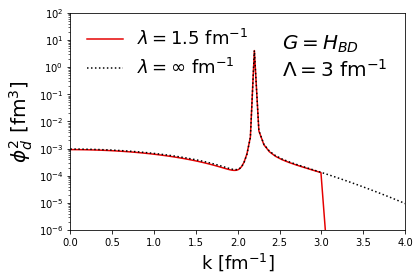

In [7]:
# Plot deuteron momentum distributions


# EM N3LO non-local potential at cutoff of 500 MeV (varying SRG generator)
# Wegner
#deuteron_momentum_distribution(10, 30.0, 4.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#deuteron_momentum_distribution(10, 30.0, 4.0, ntot, 'Block-diag', lamb, 2.00)
# Block-diagonal at 3 fm^-1
#deuteron_momentum_distribution(10, 30.0, 4.0, ntot, 'Block-diag', lamb, 3.00)

# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator)
# Wegner
#deuteron_momentum_distribution(106, 8.0, 2.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#deuteron_momentum_distribution(106, 8.0, 2.0, ntot, 'Block-diag', lamb, 2.00)

# Gezerlis et al N2LO local at cutoff 1.0 fm (varying SRG generator)
# Wegner
#deuteron_momentum_distribution(222, 10.0, 2.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#deuteron_momentum_distribution(222, 10.0, 2.0, ntot, 'Wegner', lamb, 2.00)

In [ ]:
# Plot continuum state momentum distributions


# Energy of the state in MeV
eps = 200

# EM N3LO non-local potential (varying SRG generator)
# Wegner
#continuum_state_momentum_distribution(eps, 10, 30.0, 4.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#continuum_state_momentum_distribution(eps, 10, 30.0, 4.0, ntot, 'Block-diag', lamb, 2.00)
# Block-diagonal at 3 fm^-1
#continuum_state_momentum_distribution(eps, 10, 30.0, 4.0, ntot, 'Block-diag', lamb, 3.00)

# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator)
# Wegner
#continuum_state_momentum_distribution(eps, 106, 8.0, 2.0, ntot, 'Wegner', lamb)
# Block-diagonal at 2 fm^-1
#continuum_state_momentum_distribution(eps, 106, 8.0, 2.0, ntot, 'Block-diag', lamb, 2.00)
# Block-diagonal at 3 fm^-1
#continuum_state_momentum_distribution(eps, 106, 8.0, 2.0, ntot, 'Block-diag', lamb, 3.00)